In [ ]:
!wget https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip

--2022-01-20 18:47:08--  https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip
Resolving dbdmg.polito.it (dbdmg.polito.it)... 130.192.163.163
Connecting to dbdmg.polito.it (dbdmg.polito.it)|130.192.163.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18640208 (18M) [application/zip]
Saving to: ‘DSL2122_january_dataset.zip’

DSL2122_january_dat 100%[===================>]  17.78M  12.5MB/s    in 1.4s    

2022-01-20 18:47:11 (12.5 MB/s) - ‘DSL2122_january_dataset.zip’ saved [18640208/18640208]



In [ ]:
!unzip DSL2122_january_dataset.zip

Archive:  DSL2122_january_dataset.zip
   creating: DSL2122_january_dataset/
  inflating: DSL2122_january_dataset/development.csv  
  inflating: __MACOSX/DSL2122_january_dataset/._development.csv  
  inflating: DSL2122_january_dataset/sample_submission.csv  
  inflating: __MACOSX/DSL2122_january_dataset/._sample_submission.csv  
  inflating: DSL2122_january_dataset/evaluation.csv  
  inflating: __MACOSX/DSL2122_january_dataset/._evaluation.csv  


In [ ]:
# Matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates
%matplotlib inline


# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, \
 accuracy_score, f1_score, precision_score, recall_score, plot_roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE


# nltk
import nltk
from nltk.tokenize import word_tokenize, WordPunctTokenizer, TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import *


# Utilities
import re
import numpy as np
import pandas as pd
import os
from collections import Counter
import time
from bs4 import BeautifulSoup
import datetime as dt
from prettytable import PrettyTable
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet') 

We load our data using pandas' dataframe.

In [ ]:
df = pd.read_csv("DSL2122_january_dataset/development.csv", infer_datetime_format=True, parse_dates=["date"], encoding='latin-1') # Developing dataframe

/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1212: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


The flag *infer_datatime_format* is set to True to easily parse the column date, as we specify it with the *parse_dates* argument.

In [ ]:
eval_df = pd.read_csv("DSL2122_january_dataset/evaluation.csv", encoding='latin-1')

In [ ]:
# we'll use the combination of the two datasets to fit the TFIDF Vectorizer
df_merged = pd.concat([pd.read_csv("DSL2122_january_dataset/development.csv", encoding='latin-1'), pd.read_csv("DSL2122_january_dataset/evaluation.csv", encoding='latin-1')])

# Exploratory Data Analysis (EDA)



In [ ]:
df.head()

We drop duplicated rows because they are useless in our analysis and  we can often find them in this kind of datasets taken from rich sources.

In [ ]:
print('Shape before dropping duplicates: ', df.shape)
df = df.drop_duplicates() # Duplicates
print('Shape after dropping duplicates: ', df.shape)

Shape before dropping duplicates:  (224994, 6)
Shape after dropping duplicates:  (224994, 6)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224994 entries, 0 to 224993
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   sentiment  224994 non-null  int64         
 1   ids        224994 non-null  int64         
 2   date       224994 non-null  datetime64[ns]
 3   flag       224994 non-null  object        
 4   user       224994 non-null  object        
 5   text       224994 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 12.0+ MB


In [ ]:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74999 entries, 0 to 74998
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ids     74999 non-null  int64 
 1   date    74999 non-null  object
 2   flag    74999 non-null  object
 3   user    74999 non-null  object
 4   text    74999 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.9+ MB


Since there are not null values in our dataframes, we won't need to handle missing values.

In [ ]:
df.user.unique().shape

(10647,)

In [ ]:
eval_df.user.unique().shape

(10647,)

Usernames for both datasets are in the same number, we'll try to use user as a feature for our model as we expect some correlation between them and the sentiment

In [ ]:
df.flag.unique()

array(['NO_QUERY'], dtype=object)

There's only a value for the column flag, this won't be a useful feature

In [ ]:
df.ids.unique().shape

(224716,)

In [ ]:
df.groupby('ids').filter(lambda g: len(g) > 1).sort_values(by='ids')

,sentiment,ids,date,flag,user,text
210646,1,1468503801,2009-04-07 02:04:18,NO_QUERY,tinknevertalks,@redtoffee Strawberry is the absolute best Ang...
195980,0,1468503801,2009-04-07 02:04:18,NO_QUERY,tinknevertalks,@redtoffee Strawberry is the absolute best Ang...
36472,0,1468652839,2009-04-07 02:58:23,NO_QUERY,revjesse,@ecaps1 bloody idiot!! just shop him into so...
34279,1,1468652839,2009-04-07 02:58:23,NO_QUERY,revjesse,@ecaps1 bloody idiot!! just shop him into so...
189102,0,1469267615,2009-04-07 05:49:29,NO_QUERY,davideggleton,"Today is very cold, so cold I may have to star..."
...,...,...,...,...,...,...
36574,1,2190936117,2009-06-16 04:07:10,NO_QUERY,Elliethinks,@iampsychic awh I'LL BE THERE!
196428,1,2191418783,2009-06-16 05:14:05,NO_QUERY,Kazcita,@Bass_ I'd appreciate one if you can rustle it...
65499,0,2191418783,2009-06-16 05:14:05,NO_QUERY,Kazcita,@Bass_ I'd appreciate one if you can rustle it...
144748,1,2191714137,2009-06-16 05:50:01,NO_QUERY,drthomasho,@BigDaveP I can't get over that Letterman is f...


In [ ]:
df.groupby('ids').filter(lambda g: len(g) > 1).shape

(556, 6)

In [ ]:
df.drop(df.groupby('ids').filter(lambda g: len(g) > 1).index, axis=0, inplace=True)

In [ ]:
df.shape

(224438, 6)

We found out records with the same id but different labels

Let's see if there's some imbalancing:

In [ ]:
df.sentiment.value_counts()

1    130157
0     94837
Name: sentiment, dtype: int64

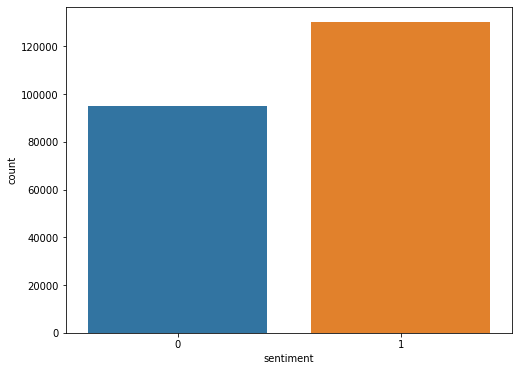

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x='sentiment', data=df)

This kind of imbalancing might be a concern.

/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


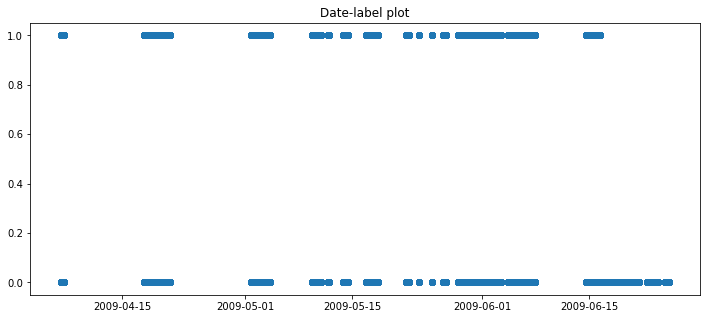

In [ ]:
x_values = df.date
y_values = df.sentiment

dates = matplotlib.dates.date2num(x_values)
plt.figure(figsize=(12, 5))
plt.title('Date-label plot')
plt.plot_date(dates, y_values)
plt.savefig('date_plot.png')

As we can see, for certain time periods there could be some correletion between dates and sentiments.

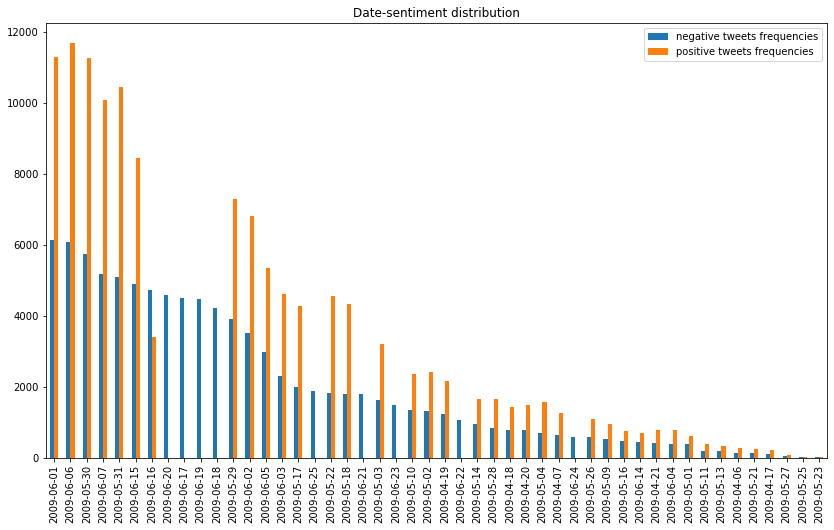

In [ ]:
df_neg = df.query('sentiment==0')
df_pos = df.query('sentiment==1')


neg_freq = df_neg['date'].dt.date.value_counts().rename('negative tweets frequencies')
pos_freq = df_pos['date'].dt.date.value_counts().rename('positive tweets frequencies')

freq = pd.concat([neg_freq, pos_freq], axis=1)
fig = freq.plot.bar(figsize=(14, 8), title='Date-sentiment distribution').get_figure()
fig.savefig('dates_double_bar.jpg')

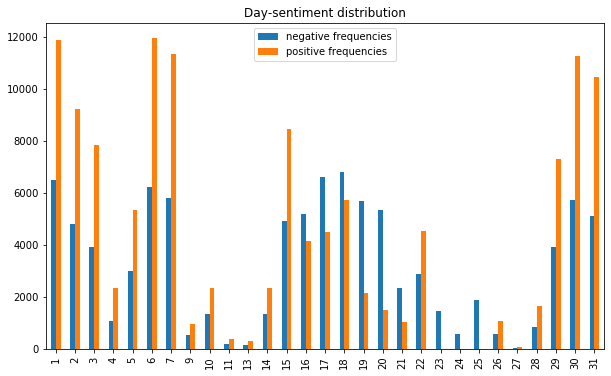

In [ ]:
df_neg = df.query('sentiment==0')
df_pos = df.query('sentiment==1')


neg_freq = df_neg['date'].dt.day.value_counts().rename('negative frequencies')
pos_freq = df_pos['date'].dt.day.value_counts().rename('positive frequencies')

freq = pd.concat([neg_freq, pos_freq], axis=1)
fig = freq.plot.bar(figsize=(10, 6), title='Day-sentiment distribution').get_figure()
fig.savefig('day_double_bar.png')

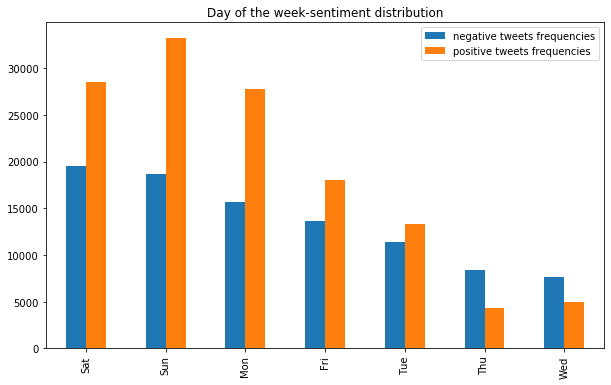

In [ ]:
df_neg = df.query('sentiment==0')
df_pos = df.query('sentiment==1')


neg_freq = df_neg['date'].dt.dayofweek.map({0: 'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}).value_counts().rename('negative tweets frequencies')
pos_freq = df_pos['date'].dt.dayofweek.map({0: 'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}).value_counts().rename('positive tweets frequencies')

freq = pd.concat([neg_freq, pos_freq], axis=1)
fig = freq.plot.bar(figsize=(10, 6), title='Day of the week-sentiment distribution').get_figure()
fig.savefig('double_bar.png')

The day of the week could be an important feature for our analysis

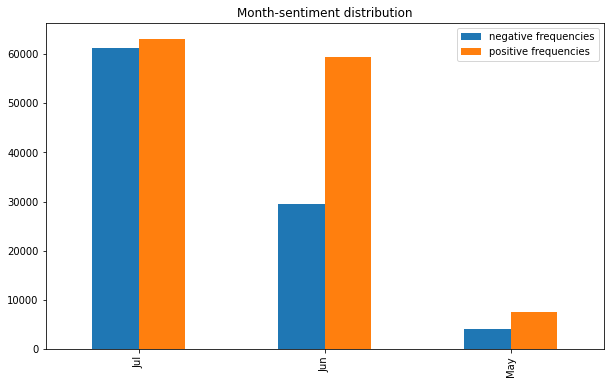

In [ ]:
df_neg = df.query('sentiment==0')
df_pos = df.query('sentiment==1')


neg_freq = df_neg['date'].dt.month.map({0: 'Jan', 1:'Feb', 2:'Mar', 3:'Apr', 4:'May', 5:'Jun', 6:'Jul', 7:'Aug', 8:'Sep', 9:'Oct', 10:'Nov', 11:'Dec'}).value_counts().rename('negative frequencies')
pos_freq = df_pos['date'].dt.month.map({0: 'Jan', 1:'Feb', 2:'Mar', 3:'Apr', 4:'May', 5:'Jun', 6:'Jul', 7:'Aug', 8:'Sep', 9:'Oct', 10:'Nov', 11:'Dec'}).value_counts().rename('positive frequencies')

freq = pd.concat([neg_freq, pos_freq], axis=1)
fig = freq.plot.bar(figsize=(10, 6), title='Month-sentiment distribution').get_figure()
fig.savefig('double_bar_month.png')

Though there's some imbalancing in sentiment class, records are equally nomerous in July, whilst in June positive tweets doubled negative ones

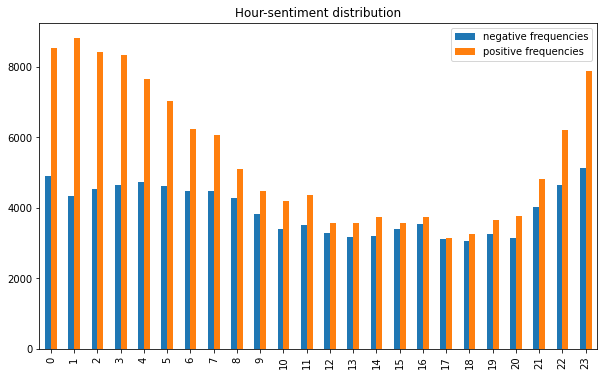

In [ ]:
df_neg = df.query('sentiment==0')
df_pos = df.query('sentiment==1')


neg_freq = df_neg['date'].dt.hour.value_counts().rename('negative frequencies')
pos_freq = df_pos['date'].dt.hour.value_counts().rename('positive frequencies')

freq = pd.concat([neg_freq, pos_freq], axis=1)
fig = freq.plot.bar(figsize=(10, 6), title='Hour-sentiment distribution').get_figure()
fig.savefig('double_bar_month.png')

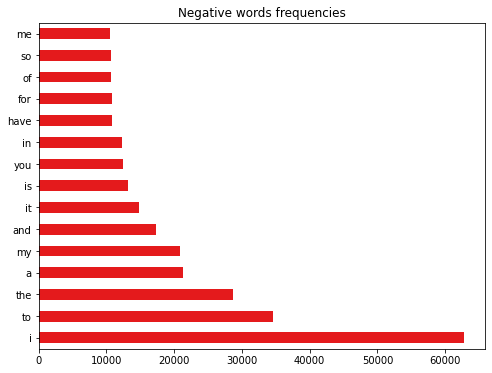

In [ ]:
df_neg = df.query('sentiment==0')
neg_freq = pd.Series(' '.join(df_neg['text']).lower().split()).value_counts()

neg_freq[:15].plot.barh(colormap='Set1', figsize=(8,6), title='Negative words frequencies')

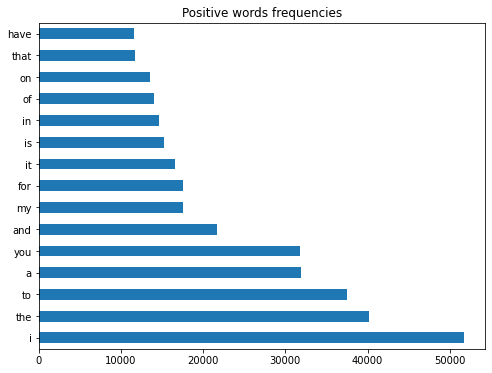

In [ ]:
df_pos = df.query('sentiment==1')
pos_freq = pd.Series(' '.join(df_pos['text']).lower().split()).value_counts()

pos_freq[:15].plot.barh(figsize=(8,6), title='Positive words frequencies')

Some usual 'stopwords' are present with the same frequency among the text from the two classes and some other aren't. Delenting stopwords from the analysis might be misleading.

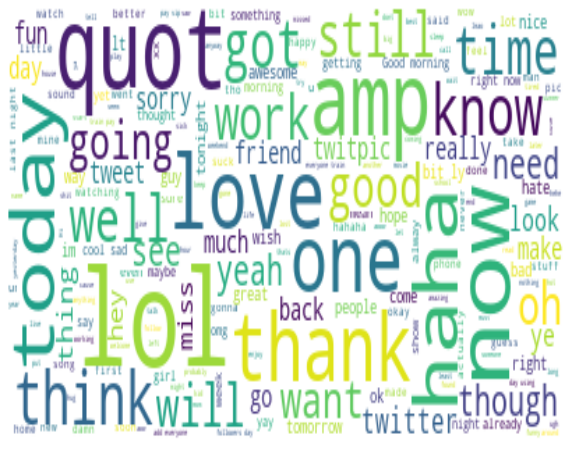

In [ ]:
text = " ".join(tweet for tweet in list(df_merged.text))

wordcloud = WordCloud(stopwords=None, background_color='white').generate(text) # a standard stopwords set is used
fig = plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.rcParams["figure.figsize"] = (8, 6)
plt.show()
fig.figure.savefig('wordcloud.png')

The first thing we can notice is that HTML character entity references like &quot and &amp are two of the biggest represented words, so we definitely need to clean the text of all references.

# First Benchmark:

We will see the score of these classifiers without any relevant preprocessing step and using only the text column as input (we apply tf-idf vectorization for text) :


In [ ]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df.text)

In [ ]:
models = [RandomForestClassifier(n_estimators=10),
          LogisticRegression(max_iter=1000),
          LinearSVC(max_iter=1000)]

names = [
'random forest',
'logistic regression',
'linear svc'
]

t = PrettyTable()
t.field_names = ['model', 'F1 macro']

for model, name in zip(models, names):
    scores = cross_val_score(model, X_tfidf, df.sentiment, cv=5, scoring='f1_macro')
    t.add_row([name, scores])
print(t)

+---------------------+----------------------------------------------------------+
|        model        |                         F1 macro                         |
+---------------------+----------------------------------------------------------+
|    random forest    | [0.73577942 0.72850186 0.73388639 0.73132185 0.73419266] |
| logistic regression | [0.784628   0.78373817 0.78511538 0.78150087 0.78315572] |
|      linear svc     | [0.78221908 0.78187169 0.78077192 0.77702541 0.78029331] |
+---------------------+----------------------------------------------------------+


Let's inspect if random forest improves with higher number of estimators:

In [ ]:
t = PrettyTable()
t.field_names = ['Num of estimators', 'Training F1 macro', 'Test F1 macro']
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.sentiment, test_size=0.2, random_state=42)

f1_scores_train = []
f1_scores_test = []
for n in range(10, 60, 10):
    rf = RandomForestClassifier(n_estimators=n)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    f1_test = f1_score(y_test, y_pred, average='macro')
    y_pred = rf.predict(X_train)
    f1_train = f1_score(y_train, y_pred, average='macro')
    f1_scores_test.append(f1_test)
    f1_scores_train.append(f1_train)
    t.add_row([n, f1_train, f1_test])
print(t)

+-------------------+--------------------+--------------------+
| Num of estimators | Training F1 macro  |   Test F1 macro    |
+-------------------+--------------------+--------------------+
|         10        | 0.9905432540204524 |  0.72791339956001  |
|         20        | 0.9974187303604697 | 0.7502518707327215 |
|         30        | 0.9984842302058159 | 0.7571804056865761 |
|         40        | 0.9986323733563311 | 0.7583835929882079 |
|         50        | 0.9987349544811899 | 0.7636887110934355 |
+-------------------+--------------------+--------------------+


Let's plot Random Forest's learning curves:

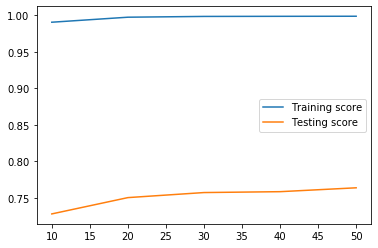

In [ ]:
x = range(10, 60, 10)
plt.plot(x, f1_scores_train, label = "Training score")
plt.plot(x, f1_scores_test, label= "Testing score")
plt.legend()
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.sentiment, test_size=0.2, random_state=42)

svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("Accuracy on test set: ", accuracy_score(y_test, y_pred))
print("F1 score on test set: ", f1_score(y_test, y_pred, average='macro'))

Accuracy on test set:  0.8000400008889087
F1 score on test set:  0.7921767475343384


We will use LogisticRegression to rapidly asses our choices.

Let's try a particular tokenizer, which considers raw punctuation as tokens, together with a Lemmatizer and let's eliminate stopwords from our analysis:



In [ ]:
class LemmaTokenizer(object):
  def __init__(self):
    self.lemmatizer = WordNetLemmatizer()
    self.tokenizer = WordPunctTokenizer()


  def __call__(self, document):
    lemmas = []
    for token in self.tokenizer.tokenize(document):
      token = token.strip()
      lemma = self.lemmatizer.lemmatize(token)
      lemmas.append(lemma)
    return lemmas

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words=stopwords.words('english'))
X_tfidf = vectorizer.fit_transform(df.text)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.sentiment, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy on test set: ", accuracy_score(y_test, y_pred))
print("F1 score on test set: ", f1_score(y_test, y_pred, average='macro'))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'doe', 'ha', 'wa'] not in stop_words.
  % sorted(inconsistent)


Accuracy on test set:  0.7841729816218138
F1 score on test set:  0.7744888665015714


Let's try stopword removal only:


In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X_tfidf = vectorizer.fit_transform(df.text)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.sentiment, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy on test set: ", accuracy_score(y_test, y_pred))
print("F1 score on test set: ", f1_score(y_test, y_pred, average='macro'))

Accuracy on test set:  0.7797284384097425
F1 score on test set:  0.7694959532834751


It's clear that both lemmatization and stopword removal worsen the performances. This can happen because abbreviations, like punctuation, can be relevant to sentiment detection.
Moreover, the default tokenization used by TfidfVectorizer explicitly ignores all punctuation and this caused the last score being lower than the previous one.



# **Preprocessing**:

In our cleaning pipeline, we remove all the # and @ from our text, then we identify url and words with trailing repeted characters using regular expressions:


1.   we eliminate all the HTML references 
2.   we substitute every url with the *URL* keyword
3.   we bring to 2 the number of repeted characters in a word
4.   we eliminate # and @ symbols



In [ ]:
def tweet_cleaner(text):
  urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
  rptPattern = re.compile(r"(.)\1{1,}", re.IGNORECASE);

  soup = BeautifulSoup(text, 'lxml')
  tweet = soup.get_text().encode('latin1').decode('utf-8')

  try:
    tweet = tweet.encode('latin1').decode('utf-8')
  except:
    pass

  tweet.lower()
    
  tweet = tweet.replace('�', "'")
  tweet = re.sub(r'@', '', tweet)
  tweet = re.sub(r'#', '', tweet)
  tweet = re.sub(urlPattern, ' URL', tweet)
  tweet = re.sub(rptPattern, rpt_repl, tweet)
  
  return tweet


# To substitute repeating letters
def rpt_repl(match):
    return match.group(1)+match.group(1)

In [ ]:
class Tokenizer(object):
  def __init__(self):
    self.tokenizer = TweetTokenizer()


  def __call__(self, document):
    return self.tokenizer.tokenize(document)


tknzr = Tokenizer()

Performance with text cleaning:

In [ ]:
X_cleaned = df['text'].map(lambda tweet: tweet_cleaner(tweet))

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=tknzr)
X_cleaned =  vectorizer.fit_transform(X_cleaned)

In [ ]:
models = [RandomForestClassifier(n_estimators=50),
          LogisticRegression(max_iter=1000),
          LinearSVC(max_iter=1000)]
names = [
'random forest',
'logistic regression',
'linear svc'
]

In [ ]:
t = PrettyTable()
t.field_names = ['model', 'F1 macro']

for model, name in zip(models, names):
    scores = cross_val_score(model, X_cleaned, df.sentiment, cv=5, scoring='f1_macro')
    t.add_row([name, scores])
print(t)

+---------------------+----------------------------------------------------------+
|        model        |                         F1 macro                         |
+---------------------+----------------------------------------------------------+
|    random forest    | [0.75985024 0.75875551 0.75723487 0.7574411  0.75991351] |
| logistic regression | [0.78963971 0.79024494 0.79011985 0.78530296 0.78931143] |
|      linear svc     | [0.78623669 0.78722606 0.78655454 0.78213241 0.78503181] |
+---------------------+----------------------------------------------------------+


New features selection:


1.   One-hot encoded usernames
2.   From the *date* column, we extract the date (yyyy-mm-dd), week-day, hour and month, we add one column for each of them to the dataframe and, finally, we use the one-hot encoded version of them as feature



In [ ]:
# one-hot for user
df = pd.concat([pd.DataFrame(pd.get_dummies(df.user)), df.drop(columns=['user'])], axis=1)

# We use date, dat of the week, month and hour as features one hot encoded

df['day_of_the_week'] = df['date'].dt.dayofweek
df['day_of_the_week'] = df['day_of_the_week'].map({0: 'Mon', 1:'Tue', 2:'Wen', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})
df['_hour_'] = df['date'].dt.hour
df['_month_'] = df['date'].dt.month
df['_month_'] = df['_month_'].map({0: 'Jan', 1:'Feb', 2:'Mar', 3:'Apr', 4:'May', 5:'Jun', 6:'Jul', 7:'Aug', 8:'Sep', 9:'Oct', 10:'Nov', 11:'Dec'})
df['_date_'] = df['date'].dt.date
df = pd.concat([pd.DataFrame(pd.get_dummies(df['_date_'])), pd.DataFrame(pd.get_dummies(df['day_of_the_week'])),\
               pd.DataFrame(pd.get_dummies(df['_hour_'])), pd.DataFrame(pd.get_dummies(df['_month_'])),\
               df.drop(columns=['date', 'day_of_the_week', '_hour_', '_month_', '_date_'])], axis=1)

Performance after feature selection:

In [ ]:
df['text'] = df['text'].map(lambda tweet: tweet_cleaner(tweet))

In [ ]:
t = PrettyTable()
t.field_names = ['Model', 'F1 macro']

vectorizer = TfidfVectorizer(tokenizer=tknzr)

# construct the column transfomer
column_transformer = ColumnTransformer(
    [('tfidf', vectorizer, 'text')],
    remainder='passthrough')

for model, name in zip(models, names):
    pipe = Pipeline([
                ('ct', column_transformer),
                ('classify', model)
                ])
    scores = cross_val_score(pipe, df.drop(columns=['sentiment', 'flag', 'ids']), df.sentiment, cv=5, scoring='f1_macro')
    t.add_row([name, scores])
print(t)

# Tf-idf Hyperparameters tuning

In [ ]:
X, y = pd.concat([X_train_preprocessed, X_test_preprocessed]), pd.concat([y_train, y_test])

In [ ]:
# initialise model and vectorizers
model = LogisticRegression(max_iter=2000, n_jobs=-1)
vectorizer = TfidfVectorizer(tokenizer=tknzr)

# construct the column transfomer
column_transformer = ColumnTransformer(
    [('tfidf', vectorizer, 'text')],
    remainder='passthrough')

#model.fit(X_transf, y)
pipe = Pipeline([
                  ('ct', column_transformer),
                  ('classify', model)
                ])

In [ ]:
gs = GridSearchCV(pipe,
             param_grid={'ct__tfidf__ngram_range': [(1, 2), (1, 3)],
                        'ct__tfidf__max_features': [50000, 60000, 70000],
                        'ct__tfidf__max_df': [0.3, 0.5, 0.7],
                        'ct__tfidf__min_df': [1, 2, 3]},
             cv=5,
             scoring='f1_macro',
             refit=True,
             verbose=1)

gs.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1632: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1
/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/students/s292129/.local/lib/

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tfidf',
                                                                         TfidfVectorizer(tokenizer=<__main__.Tokenizer object at 0x7f8005e98f90>),
                                                                         'text')])),
                                       ('classify',
                                        LogisticRegression(max_iter=2000,
                                                           n_jobs=-1))]),
             param_grid={'ct__tfidf__max_df': [0.3, 0.5, 0.7],
                         'ct__tfidf__max_features': [60000, 70000],
                         'ct__tfidf__min_df': [1, 2, 3],
                         'ct__tfidf__ngram_range': [(1, 2), (1, 3)]},
             scoring='f1_macro', verbose=1)

In [ ]:
gs.best_params_

{'ct__tfidf__max_df': 0.5,
 'ct__tfidf__max_features': 60000,
 'ct__tfidf__min_df': 1,
 'ct__tfidf__ngram_range': (1, 3)}

In [ ]:
# initialise model and vectorizers
model = LogisticRegression(max_iter=2000, n_jobs=-1)
vectorizer = TfidfVectorizer(tokenizer=tknzr, max_df=0.5, min_df=1, ngram_range=(1, 3))

# construct the column transfomer
column_transformer = ColumnTransformer(
    [('tfidf', vectorizer, 'text')],
    remainder='passthrough')

#model.fit(X_transf, y)
pipe = Pipeline([
                  ('ct', column_transformer),
                  ('classify', model)
                ])

In [ ]:
gs = GridSearchCV(pipe,
             param_grid={
                        'ct__tfidf__max_features': [40000, 50000, 60000],
             },       
             cv=5,
             scoring='f1_macro',
             refit=True,
             verbose=1)

gs.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1632: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1
/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1632: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1
/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWa

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tfidf',
                                                                         TfidfVectorizer(max_df=0.5,
                                                                                         ngram_range=(1,
                                                                                                      3),
                                                                                         tokenizer=<__main__.Tokenizer object at 0x7f8005e98f90>),
                                                                         'text')])),
                                       ('classify',
                                        LogisticRegression(max_iter=2000,
                                                           n_jobs=-1))]),
             param_grid={'

In [ ]:
gs.best_params_

{'ct__tfidf__max_features': 60000}

# Model selection

In [ ]:
models = [RandomForestClassifier(n_estimators=50),
          LogisticRegression(max_iter=1000),
          LinearSVC(max_iter=1000)]

names = [
'random forest',
'logistic regression',
'linear svc'
]

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=tknzr, max_features=60000, max_df=0.5, min_df=1, ngram_range=(1, 3))
t = PrettyTable()
t.field_names = ['Model', 'F1 macro']

# construct the column transfomer
column_transformer = ColumnTransformer(
    [('tfidf', vectorizer, 'text')],
    remainder='passthrough')

for model, name in zip(models, names):
    pipe = Pipeline([
                ('ct', column_transformer),
                ('classify', model)
                ])
    scores = cross_val_score(pipe, df.drop(columns=['sentiment', 'flag', 'ids']), df.sentiment, cv=5, scoring='f1_macro')
    t.add_row([name, scores])
print(t)

/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['date', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1632: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1
/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['date', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1632: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1
/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/utils/validation.p

+---------------------+----------------------------------------------------------+
|        Model        |                         F1 macro                         |
+---------------------+----------------------------------------------------------+
|    random forest    | [0.78649333 0.79386328 0.79019595 0.78528319 0.78380481] |
| logistic regression | [0.85499166 0.85672041 0.85481362 0.85322957 0.85742865] |
|      linear svc     | [0.84361729 0.84695259 0.84418423 0.84348806 0.84836944] |
+---------------------+----------------------------------------------------------+


Let's test SVC too:

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=tknzr, max_features=60000, max_df=0.5, min_df=1, ngram_range=(1, 3))

column_transformer = ColumnTransformer(
    [('tfidf', vectorizer, 'text')],
    remainder='passthrough')

svm = SVC()

pipe = Pipeline([
            ('ct', column_transformer),
            ('classify', svm)
            ])
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['sentiment', 'flag', 'ids']), df.sentiment, test_size=0.2, random_state=42)
pipe.fit(X_train, y_train)

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
print("Test accuracy", accuracy_score(y_test, y_pred))
print("Test f1 score: ",f1_score(y_test, y_pred, average='macro'))

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
print(confusion_matrix(y_test, y_pred))

# Model hyperparameters tuning

Let's make a grid search for our chosen model:

In [ ]:
# initialise model and vectorizers
model = LogisticRegression(max_iter=2000, n_jobs=-1)
vectorizer = TfidfVectorizer(tokenizer=tknzr, max_features=60000, max_df=0.5, min_df=1, ngram_range=(1, 3))

# construct the column transfomer
column_transformer = ColumnTransformer(
    [('tfidf', vectorizer, 'text')],
    remainder='passthrough')

#model.fit(X_transf, y)
pipe = Pipeline([
                  ('ct', column_transformer),
                  ('classifier', model)
                ])

In [ ]:
param_grid = [
    {'classifier__C' : np.logspace(-4, 4, 20)}
]

# Create grid search object

gs = GridSearchCV(pipe,
             param_grid=param_grid,       
             cv=5,
             scoring='f1_macro',
             refit=True,
             verbose=True)

gs.fit(X, y)

In [ ]:
gs.best_params_

{'classifier__C': 1.623776739188721}

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=tknzr, max_features=60000, max_df=0.5, min_df=1, ngram_range=(1, 3))

column_transformer = ColumnTransformer(
    [('tfidf', vectorizer, 'text')],
    remainder='passthrough')

clf = LogisticRegression(C=1.623776739188721, max_iter=2000, n_jobs=-1)

pipe = Pipeline([
            ('ct', column_transformer),
            ('classify', clf)
            ])

scores = cross_val_score(pipe, df.drop(columns=['sentiment', 'flag', 'ids']), df.sentiment, cv=5, scoring='f1_macro')

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83     19068
           1       0.86      0.91      0.88     25931

    accuracy                           0.86     44999
   macro avg       0.86      0.85      0.86     44999
weighted avg       0.86      0.86      0.86     44999



Let's plot confusion matrix and ROC curve for Logistic Regression:

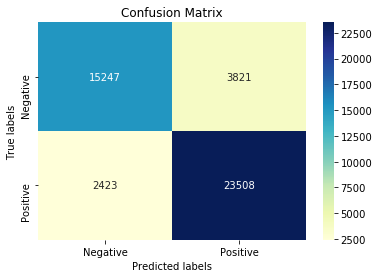

In [ ]:
# Conf Matrix
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), cmap='YlGnBu', annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive'])
ax.figure.savefig('conf_matrix.png')

/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


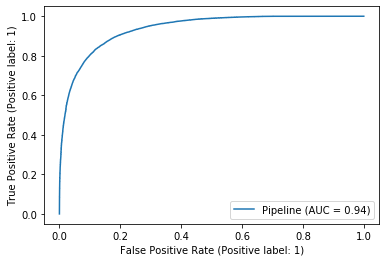

In [ ]:
plot_roc_curve(pipe, X_test, y_test)

Let's plot the learning curves:

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=tknzr, max_features=60000, max_df=0.5, min_df=1, ngram_range=(1, 3))
column_transformer = ColumnTransformer(
    [('tfidf', vectorizer, 'text')],
    remainder='passthrough')

clf = LogisticRegression(C=1.623776739188721, max_iter=2000, n_jobs=-1)

pipe = Pipeline([
            ('ct', column_transformer),
            ('classify', clf)
            ])

f1_scores_test = []
f1_scores_train = []
for perc in (0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1):
    df_sample = df.sample(frac=perc)
    X_train, X_test, y_train, y_test = train_test_split(df_sample.drop(columns=['sentiment', 'flag', 'ids']), df_sample.sentiment, test_size=0.2, random_state=42)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    f1_scores_test.append(f1_score(y_test, y_pred, average='macro'))
    y_pred = pipe.predict(X_train)
    f1_scores_train.append(f1_score(y_train, y_pred, average='macro'))


/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['date', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1632: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1
/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['date', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1632: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1
/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/utils/validation.p

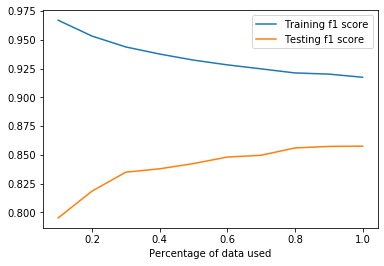

In [ ]:
# plot lines
x = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1]
plt.plot(x, f1_scores_train, label = "Training f1 score")
plt.plot(x, f1_scores_test, label= "Testing f1 score")
plt.legend()
plt.xlabel("Percentage of data used")
plt.savefig('learning_curves.png')
plt.show()

# Submission

In [ ]:
df = pd.read_csv("DSL2122_january_dataset/evaluation.csv", infer_datetime_format=True, parse_dates=["date"], encoding='latin-1')

In [ ]:
# one-hot for user

df = pd.concat([pd.DataFrame(pd.get_dummies(df.user)), df.drop(columns=['user'])], axis=1)

# We use date, weekday, month and hour as features one hot encoded

df['day_of_the_week'] = df['date'].dt.dayofweek
df['day_of_the_week'] = df['day_of_the_week'].map({0: 'Mon', 1:'Tue', 2:'Wen', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})
df['_hour_'] = df['date'].dt.hour
df['_month_'] = df['date'].dt.month
df['_month_'] = df['_month_'].map({0: 'Jan', 1:'Feb', 2:'Mar', 3:'Apr', 4:'May', 5:'Jun', 6:'Jul', 7:'Aug', 8:'Sep', 9:'Oct', 10:'Nov', 11:'Dec'})
df = pd.concat([pd.DataFrame(pd.get_dummies(df['day_of_the_week'])), \
               pd.DataFrame(pd.get_dummies(df['_hour_'])), pd.DataFrame(pd.get_dummies(df['_month_'])), df.drop(columns=['date', 'day_of_the_week', '_hour_', '_month_'])], axis=1)

Eval with pipeline:

In [ ]:
df['text'] = df['text'].map(lambda tweet: tweet_cleaner(tweet))

In [ ]:
y_eval = pipe.predict(df.drop(columns=['ids', 'flag']))
submit = pd.Series(y_eval, range(len(y_eval)))
submit.to_csv("eval_292129.csv", index_label="Id", header=["Predicted"])

# EXTRA - Dealing with class imbalance:

In [ ]:
vectorizer = TfidfVectorizer()
lr = LogisticRegression(max_iter = 1000, n_jobs=-1)

In [ ]:
def lr_cv(splits, X, Y, pipeline, average_method):
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X.iloc[train], Y.iloc[train])
        prediction = lr_fit.predict(X.iloc[test])
        scores = lr_fit.score(X.iloc[test],Y.iloc[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y.iloc[test], prediction, average=average_method)*100)
        print('              negative         positive')
        print('precision:', precision_score(Y.iloc[test], prediction, average=None))
        recall.append(recall_score(Y.iloc[test], prediction, average=average_method)*100)
        print('recall:   ', recall_score(Y.iloc[test], prediction, average=None))
        f1.append(f1_score(Y.iloc[test], prediction, average=average_method)*100)
        print('f1 score: ', f1_score(Y.iloc[test], prediction, average='macro'))
        print('-' * 50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))


In [ ]:
original_pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', lr)
])

lr_cv(5, df.text, df.sentiment, original_pipeline, 'macro')


              negative         positive
precision: [0.77726007 0.8070073 ]
recall:    [0.72119998 0.8494161 ]
f1 score:  0.7879250916843603
--------------------------------------------------
              negative         positive
precision: [0.77666477 0.80600824]
recall:    [0.71946011 0.84926245]
f1 score:  0.7870195134142617
--------------------------------------------------
              negative         positive
precision: [0.77443652 0.80081139]
recall:    [0.71009068 0.84929507]
f1 score:  0.7826050196093102
--------------------------------------------------
              negative         positive
precision: [0.77701163 0.80572657]
recall:    [0.71884226 0.84967923]
f1 score:  0.7869576648667258
--------------------------------------------------
              negative         positive
precision: [0.7704487  0.80045813]
recall:    [0.71065535 0.84572241]
f1 score:  0.7809065179328762
--------------------------------------------------
accuracy: 79.28% (+/- 0.26%)
precision: 78.96

In [ ]:
vectorizer = TfidfVectorizer()
testing_tfidf = vectorizer.fit_transform(df.text)

smt = SMOTE(random_state=42, sampling_strategy=1, k_neighbors=1, n_jobs=-1)
X_SMOTE, y_SMOTE = smt.fit_resample(testing_tfidf, df.sentiment)
X_train, X_test, y_train, y_test = train_test_split(X_SMOTE, y_SMOTE, test_size=0.1, random_state=42)

In [ ]:
X_SMOTE.shape

(260314, 156437)

In [ ]:
X_train.shape

(234282, 156437)

In [ ]:
log_clf = LogisticRegression(max_iter = 5000, n_jobs=-1)
log_clf.fit(X_train, y_train)
y_pred = log_clf.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test, average='macro'))

Accuracy:  0.7890288875230486
f1 score:  0.788921927058263


Let's try Random Over Sampling:

In [ ]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

ros = RandomOverSampler(random_state=777)
X_ROS, y_ROS = ros.fit_resample(testing_tfidf, df.sentiment)
print(X_ROS.shape)

X_train, X_test, y_train, y_test = train_test_split(X_ROS, y_ROS, test_size=0.1, random_state=42)


log_clf = LogisticRegression(max_iter = 5000, n_jobs=-1)
log_clf.fit(X_train, y_train)
y_pred = log_clf.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test, average='macro'))

(260314, 156437)
Accuracy:  0.7884526736324524
f1 score:  0.7884283711429056


The two approaches didn't improve base models' results.